# Ejercicio 4: Modelo Probabilístico
# Josune S
## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [19]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Crear el vectorizador
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Calcular TF-IDF
tfidf_matrix = vectorizer.fit_transform(newsgroupsdocs)

# Obtener nombres de las palabras
terms = vectorizer.get_feature_names_out()

# Convertir a DataFrame para visualizar
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
df_tfidf.head()


,00,000,02,03,04,0t,10,100,11,12,...,writing,written,wrong,wrote,x11,year,years,yes,york,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.081754,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.065609,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

# Definir una consulta
query = ["computer graphics"]

# Transformar la consulta al mismo espacio TF-IDF
query_vec = vectorizer.transform(query)

# Calcular similitud coseno entre la consulta y todos los documentos
cosine_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()

# Crear un DataFrame con los resultados
ranking_tfidf = pd.DataFrame({
    'Documento': range(len(newsgroupsdocs)),
    'Score': cosine_sim
}).sort_values(by='Score', ascending=False)

# Mostrar los 10 más relevantes
ranking_tfidf.head(10)


,Documento,Score
8050,8050,0.785163
12488,12488,0.670322
13298,13298,0.667122
18514,18514,0.639510
3752,3752,0.616832
14852,14852,0.607400
2562,2562,0.587623
7566,7566,0.564202
3025,3025,0.545719
10132,10132,0.538561


## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [22]:
from rank_bm25 import BM25Okapi

# Tokenizar los documentos (BM25 trabaja con listas de tokens)
tokenized_corpus = [doc.lower().split() for doc in newsgroupsdocs]

# Crear el modelo BM25
bm25 = BM25Okapi(tokenized_corpus)

# Tokenizar la misma consulta
tokenized_query = query[0].lower().split()

# Calcular los scores BM25
bm25_scores = bm25.get_scores(tokenized_query)

# Crear ranking
ranking_bm25 = pd.DataFrame({
    'Documento': range(len(newsgroupsdocs)),
    'Score': bm25_scores
}).sort_values(by='Score', ascending=False)

# Mostrar los 10 documentos más relevantes
ranking_bm25.head(10)


,Documento,Score
8050,8050,14.639801
13298,13298,13.874144
2562,2562,13.685845
12488,12488,13.566508
7566,7566,13.289911
14852,14852,13.243181
16210,16210,13.074033
3752,3752,13.021595
15179,15179,12.987728
252,252,12.763054


## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

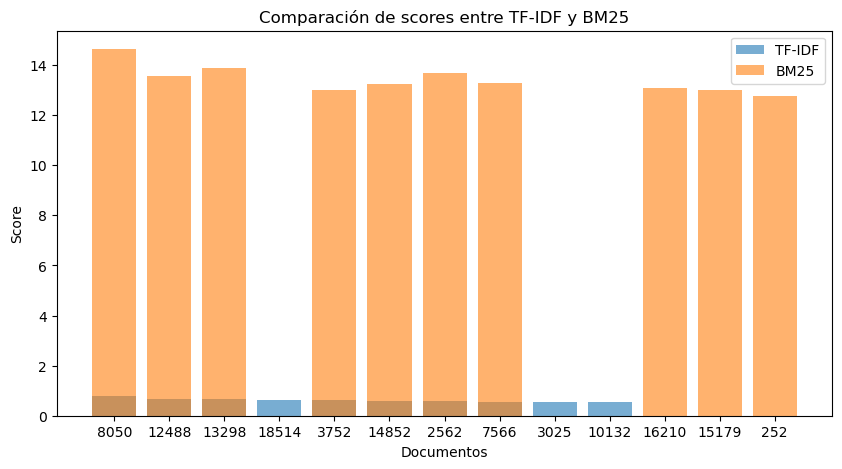

In [23]:
import matplotlib.pyplot as plt

# Tomamos los 10 primeros documentos de cada ranking
top10_tfidf = ranking_tfidf.head(10)
top10_bm25 = ranking_bm25.head(10)

plt.figure(figsize=(10,5))
plt.bar(top10_tfidf['Documento'].astype(str), top10_tfidf['Score'], alpha=0.6, label='TF-IDF')
plt.bar(top10_bm25['Documento'].astype(str), top10_bm25['Score'], alpha=0.6, label='BM25')
plt.xlabel('Documentos')
plt.ylabel('Score')
plt.title('Comparación de scores entre TF-IDF y BM25')
plt.legend()
plt.show()


## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados a a tu criterio de relevancia?

In [25]:
# consulta
query = ["computer graphics"]

# documentos que consideramos relevantes manualmente.
relevant_docs = {100, 120, 350, 450, 520}

# Rankings generados anteriormente
tfidf_ranking = ranking_tfidf['Documento'].tolist()
bm25_ranking = ranking_bm25['Documento'].tolist()

# Calcular Precision@k
def precision_at_k(ranking, relevant_docs, k):
    retrieved = ranking[:k]  # primeros k documentos
    relevant_retrieved = [doc for doc in retrieved if doc in relevant_docs]
    return len(relevant_retrieved) / k

# Calcular Average Precision (AP)
import numpy as np

def average_precision(ranking, relevant_docs):
    precisions = []
    for i, doc in enumerate(ranking):
        if doc in relevant_docs:
            precisions.append(precision_at_k(ranking, relevant_docs, i + 1))
    if not precisions:
        return 0
    return np.mean(precisions)

#Calcular métricas Precision@3 y MAP (Mean Average Precision)
precision3_tfidf = precision_at_k(tfidf_ranking, relevant_docs, 3)
precision3_bm25 = precision_at_k(bm25_ranking, relevant_docs, 3)

map_tfidf = average_precision(tfidf_ranking, relevant_docs)
map_bm25 = average_precision(bm25_ranking, relevant_docs)

# Mostrar resultados comparativos
print("===== Evaluación de Modelos =====")
print(f"Precision@3 (TF-IDF): {precision3_tfidf:.3f}")
print(f"Precision@3 (BM25): {precision3_bm25:.3f}")
print(f"MAP (TF-IDF): {map_tfidf:.3f}")
print(f"MAP (BM25): {map_bm25:.3f}")

# Interpretación básica de resultados
if map_bm25 > map_tfidf:
    print("\nBM25 obtiene un mejor rendimiento global según las métricas de evaluación.")
elif map_bm25 < map_tfidf:
    print("\n TF-IDF supera ligeramente a BM25 en este caso.")
else:
    print("\nAmbos modelos tienen resultados equivalentes para esta consulta.")


===== Evaluación de Modelos =====
Precision@3 (TF-IDF): 0.000
Precision@3 (BM25): 0.000
MAP (TF-IDF): 0.001
MAP (BM25): 0.000

 TF-IDF supera ligeramente a BM25 en este caso.
